# Assignment 3

NAME: **IFEDIORAH KENECHUKWU I.**

STUDENT ID: **9052693**


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import seaborn as sns

### 1. Obtain the date (Load the Images)

In [8]:
# This points to the subset of the dataset already created during the class activity
data_folder = pathlib.Path('../CSCN8010_Classwork/data/kaggle_dogs_vs_cats_small')

We will use the image_dataset_from_dictionary method to load and augment our images. 

In [ ]:
# define the image size and batch size
# We will use the same image size as the VGG16 model (180x180) and a batch size of 32
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 2. EDA: Exploring the data

**Check shape and form of the dataset**

In [12]:
for train_data_batch, train_labels_batch in train_dataset:
    print ('Training Data Shape:')
    print("data batch shape:", train_data_batch.shape)
    print("labels batch shape:", train_labels_batch.shape)
    break

for val_data_batch, val_labels_batch in validation_dataset:
    print ('\nValidation Data Shape:')
    print("data batch shape:", val_data_batch.shape)
    print("labels batch shape:", val_labels_batch.shape)
    break

for test_data_batch, test_labels_batch in test_dataset:
    print ('\nTesting Data Shape:')
    print("data batch shape:", test_data_batch.shape)
    print("labels batch shape:", test_labels_batch.shape)
    break

Training Data Shape:
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)

Validation Data Shape:
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)

Testing Data Shape:
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


The data batch shape (32, 180, 180, 3) explains that the images are in batches of 32, have an image size of 180 x 180 pixels and is RGB, hence the 3 at the end, since there are 3 figures representing the RGB values.



In [14]:
train_labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1])>

The labels as given in the data directories are just 0s and 1s, where:

0 - Cat

1 - Dog



**Now, we'll visualise random images from the dataset to see what the look like**

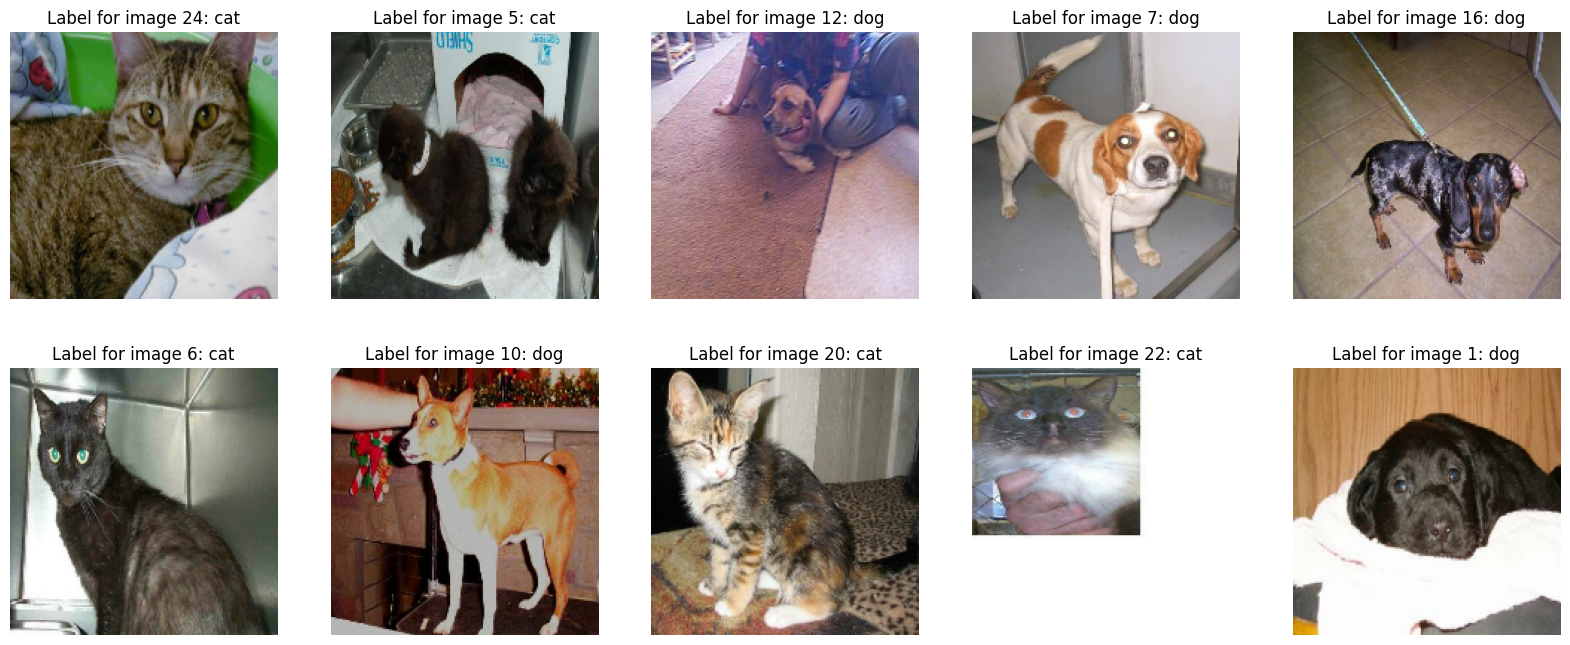

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for ax, i in zip(axes, np.random.choice(range(25), 10)):
    label = "cat" if train_labels_batch[i] == 0 else "dog"
    ax.imshow(train_data_batch[i].numpy().astype("uint8"))
    ax.axis("off") 
    ax.set_title(f"Label for image {i}: {label}")

We can see that there's a wide range of images with different sizes, orientations and positions. This is good for us, so that our model can learn to identify distinct feautures regardles of orientation and position.

We can even apply extra augmentation techniques like rotationg at random angles, zooming out or in, etc to further achieve greater variety, but we will not be doing that for this assignment.

### 3. Train Neural Networks using callbacks to save models

#### Define Vanilla CNN model

Now we will define a basic (vanilla) convolutional neural network

**Model breakdown:**

**Input Layer:** Accepts the input RGB images of shape (180, 180, 3).

**Rescaling Layer:** Normalizes pixel values to fall between 0 and 1.

**Convolutional Layers:** Five Convolutional 2D layers with increasing filters (32, 64, 128, 256, 256) and ReLU activation. This helps to extract spatial features from the images.

**MaxPooling Layers:** This comes after each Conv2D layer, except the last one, and it helps to reduce spatial dimensions while retaining important features.

**Flatten Layer:** This converts the 2D feature maps into a 1D vector.

**Dense (Output) Layer:** This layer uses the sigmoid activation (because it is binary classification) to classify images into two categories.

This model progressively extracts complex image features while reducing spatial dimensions, making it suitable for tasks like this.

In [33]:
# Define the model architecture

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vanilla_model = keras.Model(inputs=inputs, outputs=outputs)

In [36]:
vanilla_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

The model has 991, 041 trainable parameters as shown in the summary above

#### Training the Model

In [ ]:
vanilla_model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = vanilla_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 46s 720ms/step - loss: 0.6935 - accuracy: 0.5195 - val_loss: 0.6927 - val_accuracy: 0.5020
Epoch 2/30
63/63 [==============================] - 48s 765ms/step - loss: 0.6854 - accuracy: 0.5665 - val_loss: 0.6674 - val_accuracy: 0.5980
Epoch 3/30
63/63 [==============================] - 51s 802ms/step - loss: 0.6517 - accuracy: 0.6175 - val_loss: 0.6094 - val_accuracy: 0.6760
Epoch 4/30
63/63 [==============================] - 53s 834ms/step - loss: 0.6097 - accuracy: 0.6755 - val_loss: 0.5933 - val_accuracy: 0.6870
Epoch 5/30
63/63 [==============================] - 52s 817ms/step - loss: 0.5722 - accuracy: 0.7120 - val_loss: 0.7323 - val_accuracy: 0.6110
Epoch 6/30
63/63 [==============================] - 52s 817ms/step - loss: 0.5338 - accuracy: 0.7215 - val_loss: 0.5958 - val_accuracy: 0.6910
Epoch 7/30
63/63 [==============================] - 51s 814ms/step - loss: 0.4995 - accuracy: 0.7505 - val_loss: 0.5582 - val_accuracy: 0.7380

From the results above we can see that the model with the best `val_loss` was the model at epoch 9 with a validation loss of `0.5292`. This should be the model saved.

We also notice that the validation loss started increasing as the number of epochs increased even though the training loss kepty reducing. This indicates that at this point, our model started to overfit on the training data. 

We will visualize the training curve and evaluate the model to further explain what is going on.

#### Displaying the Training and Validation Loss and Accuracy curve for the Vanilla CNN model

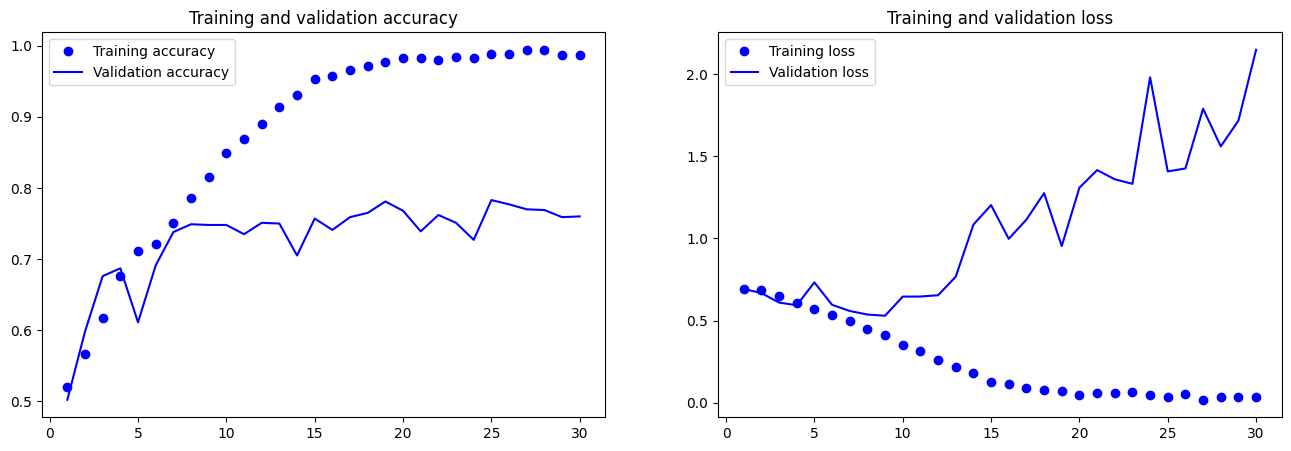

In [46]:
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

epochs = range(1, len(train_accuracy) + 1)
axes[0].plot(epochs, train_accuracy, "bo", label="Training accuracy")
axes[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
axes[0].set_title("Training and validation accuracy")
axes[0].legend()
axes[1].plot(epochs, train_loss, "bo", label="Training loss")
axes[1].plot(epochs, val_loss, "b", label="Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].legend()
plt.show()

#### Define and fine tune the VGG Model

To do this, we will:

- Load the VGG16 model
- Exclude the Fully Connected (Dense) Layers
- Define the Input Shape to be the same as our loaded dataset (180 x 180 x3)

Eventually, we will add custom layers on top of the conv_base and fine-tune it for our task.

In [52]:
# Compiling the VGG model
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [53]:
# Explore the VGG16 model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**VGG16 Model Summary:**

The VGG model comprises mostly of 5 block, each block follows this pattern:

- Conv Block: 2 or 3 convolutional layers.

- Pool Block: A single MaxPooling2D layer.

It has a total of 14,714,688 trainable parameters


We will extract features from our images using VGG16 model that we loaded `conv_base`, the preprocesses images and store the extracted features and corresponding labels for training, validation and testing sets.

This speeds up the training process and also reduces memory usage since we are running the process on CPU

In [55]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


Here we fine tune the model by adding some additional layers to the conv_base that we already have. We also freeze the trainable weights so we don't get to retrain the weights of the VGG16 model.

**Summary of the Fine Tuning Layers:**
* conv_base (Frozen VGG16) – Extracts high-level image features (not trainable).

* Flatten – Converts feature maps from conv_base into a 1D vector.

* Dense (512, ReLU) – Fully connected layer with 512 neurons to learn patterns as opposed to 256 neurons like we had in class. this doubles the trainable weights from 3 million plus to over 6 million and took the model a longer time to train

* Dropout (0.5) – Prevents overfitting by randomly deactivating 50% of neurons.

* Dense (1, Sigmoid) – Outputs a probability for binary classification.

In [58]:
# Fine tune the VGG model
conv_base.trainable = False # Freeze the base model so we don't retrain it
inputs = keras.Input(shape=(180, 180, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)
fine_tuned_model = keras.Model(inputs=inputs, outputs=x)

In [59]:
# Check the model summary
fine_tuned_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               6554112   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 513       
                                                                 
Total params: 21,269,313
Trainable params: 6,554,625
Non-tr

#### Training the Model

In [ ]:
fine_tuned_model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    ModelCheckpoint(
        filepath="./models/modified_vgg16.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = fine_tuned_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 256s 4s/step - loss: 12.0625 - accuracy: 0.8885 - val_loss: 3.2317 - val_accuracy: 0.9200
Epoch 2/30
63/63 [==============================] - 297s 5s/step - loss: 2.0188 - accuracy: 0.9580 - val_loss: 5.3436 - val_accuracy: 0.8970
Epoch 3/30
63/63 [==============================] - 252s 4s/step - loss: 1.0633 - accuracy: 0.9655 - val_loss: 1.7697 - val_accuracy: 0.9520
Epoch 4/30
63/63 [==============================] - 295s 5s/step - loss: 0.7031 - accuracy: 0.9785 - val_loss: 1.9579 - val_accuracy: 0.9510
Epoch 5/30
63/63 [==============================] - 294s 5s/step - loss: 0.7014 - accuracy: 0.9805 - val_loss: 1.7437 - val_accuracy: 0.9580
Epoch 6/30
63/63 [==============================] - 314s 5s/step - loss: 0.4355 - accuracy: 0.9870 - val_loss: 2.2022 - val_accuracy: 0.9500
Epoch 7/30
63/63 [==============================] - 308s 5s/step - loss: 0.2082 - accuracy: 0.9915 - val_loss: 1.8336 - val_accuracy: 0.9570
Epoch 8/30
6

From the results above we can see that the model with the best `val_loss` was the model at epoch 11 with a validation loss of `0.5203`. This should be the model saved.

We also notice that the validation loss started increasing as the number of epochs increased even though the training loss kepty reducing. This indicates that at this point, our model started to overfit on the training data. 

We will visualize the training curve and evaluate the model to further explain what is going on.

#### Displaying the Training and Validation Loss and Accuracy curve for the Fine-Tuned VGG16 model

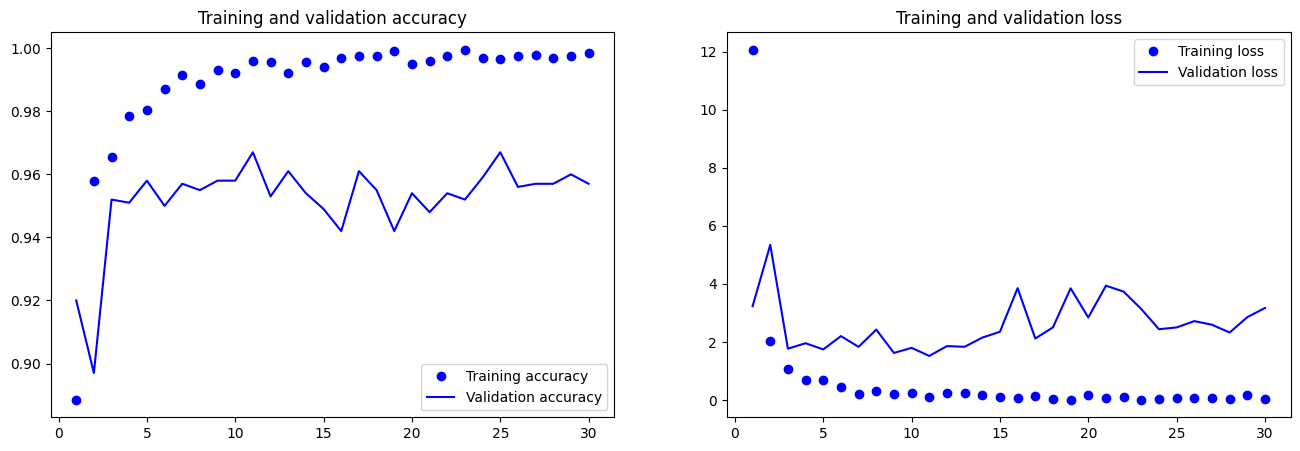

In [61]:
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

epochs = range(1, len(train_accuracy) + 1)
axes[0].plot(epochs, train_accuracy, "bo", label="Training accuracy")
axes[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
axes[0].set_title("Training and validation accuracy")
axes[0].legend()
axes[1].plot(epochs, train_loss, "bo", label="Training loss")
axes[1].plot(epochs, val_loss, "b", label="Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].legend()
plt.show()

### 4. Explore the relative performance of the models

##### a. Accuracy

In [63]:
# Load the best models (the best ones saved during training)
vanilla_model.load_weights('./models/convnet_from_scratch.keras')
fine_tuned_model.load_weights('./models/modified_vgg16.keras')

In [64]:
vanilla_model_loss, vanilla_model_acc = vanilla_model.evaluate(test_dataset)
fine_tuned_model_loss, fine_tuned_model_acc = fine_tuned_model.evaluate(test_dataset)

print(f"Vanilla CNN Accuracy: {vanilla_model_acc}")
print(f"Fine-Tuned VGG16 Accuracy: {fine_tuned_model_acc}")

63/63 [==============================] - 163s 3s/step - loss: 1.8989 - accuracy: 0.9665
Vanilla CNN Accuracy: 0.7294999957084656
Fine-Tuned VGG16 Accuracy: 0.9664999842643738


The Fine-Tuned VGG16 model performs way better than the Vanilla CNN model with an accuracy of `0.9665` compared to `0.7265`. Even though we observe that the loss is higher for the VGG16 model.

#### b. Confusion Matrix for both models

In [85]:
y_pred_vanilla = vanilla_model.predict(test_dataset)

63/63 [==============================] - 10s 153ms/step


In [87]:
y_pred_vanilla = (y_pred_vanilla > 0.5).astype("int32")

In [88]:
y_pred_vanilla

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [89]:
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy())  # Convert Tensor to NumPy and store in list

y_true = np.array(y_true).reshape(-1, 1)
y_true

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

63/63 [==============================] - 10s 153ms/step
Vanilla CNN Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1000
           1       0.70      0.79      0.75      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



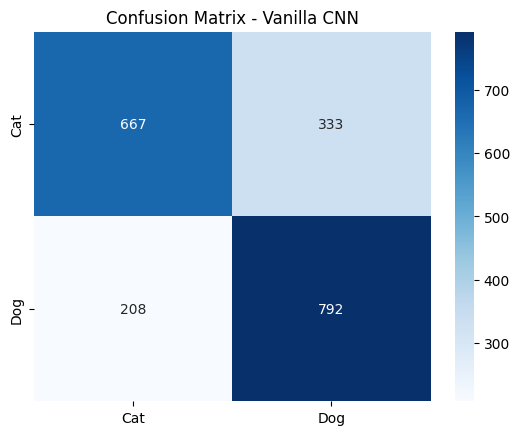

In [98]:
# --- Convert test dataset to NumPy arrays ---
test_images_list = []
test_labels_list = []

for images, labels in test_dataset:  # Take 5 batches
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

test_images = np.concatenate(test_images_list)
test_labels = np.concatenate(test_labels_list)

y_pred_vanilla = vanilla_model.predict(test_images)
y_pred_vanilla = (y_pred_vanilla > 0.5).astype("int32")

cm_vanilla = confusion_matrix(test_labels, y_pred_vanilla)
print("Vanilla CNN Classification Report:")
print(classification_report(test_labels, y_pred_vanilla))

# Plot confusion matrix
sns.heatmap(cm_vanilla, annot=True, fmt="d", cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix - Vanilla CNN")
plt.show()

63/63 [==============================] - 158s 3s/step
VGG16 Fine-Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



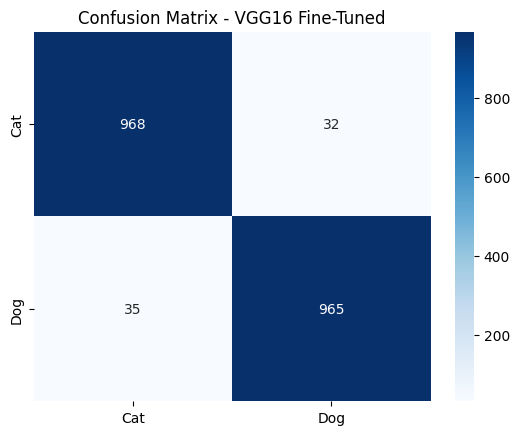

In [99]:
y_pred_vgg = fine_tuned_model.predict(test_images)
y_pred_vgg = (y_pred_vgg > 0.5).astype("int32")

cm_vgg = confusion_matrix(test_labels, y_pred_vgg)
print("VGG16 Fine-Tuned Classification Report:")
print(classification_report(test_labels, y_pred_vgg))

# Plot confusion matrix
sns.heatmap(cm_vgg, annot=True, fmt="d", cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix - VGG16 Fine-Tuned")
plt.show()


From the Confusion Matrix, its quite clear that the VGG 16 outperforms the the Vanilla CNN model by a lot.

|**Metric**|     Fine tuned VGG16 |  Vanilla CNN  |
|----------|----------------------|---------------|
|**Precision:**|  0.97  |  0.73|
|**Recall:**|   0.97    |  0.73|
|**F1-Score:**| 0.97    |  0.73|

From the results of the metrics, Precision, Recall and F1 Score, we can easily detect the improvement in performance and this makes sense because unlike the Vanilaa CNN model, the VGG16 has already undergone training on a larger dataset and even optimization before being put out to the public for use.

63/63 [==============================] - 157s 2s/step


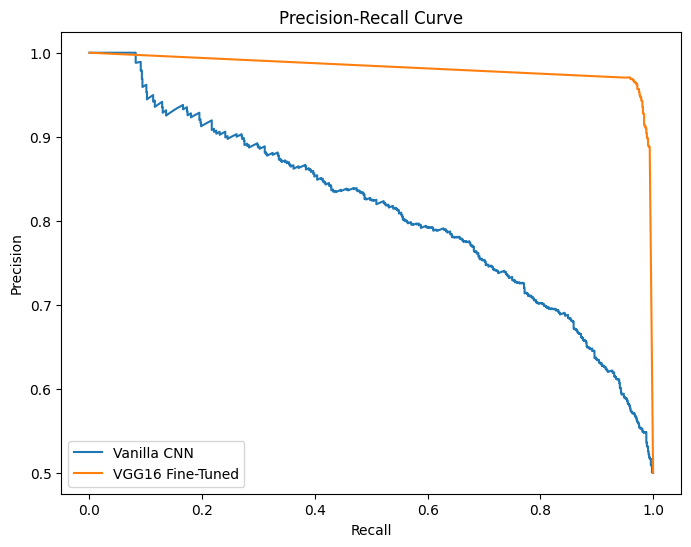

In [102]:
from sklearn.metrics import precision_recall_curve
precision_vanilla, recall_vanilla, _ = precision_recall_curve(test_labels, vanilla_model.predict(test_images))
precision_vgg, recall_vgg, _ = precision_recall_curve(test_labels, fine_tuned_model.predict(test_images))

plt.figure(figsize=(8,6))
plt.plot(recall_vanilla, precision_vanilla, label='Vanilla CNN')
plt.plot(recall_vgg, precision_vgg, label='VGG16 Fine-Tuned')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

The Precision-Recall curve compares the performance of the Vanilla CNN and the Fine-Tuned VGG16 model and shows the same results like we already stated above.

**VGG16 Fine-Tuned (Orange Curve):** Maintains high precision across almost all recall values, indicating strong performance with fewer false positives.

**Vanilla CNN (Blue Curve):** Shows a steady decline in precision as recall increases, meaning it struggles to balance precision and recall effectively.

**Summary:** The fine-tuned VGG16 model significantly outperforms the Vanilla CNN, achieving better precision at all recall levels.

Some examples where the Vanilla CNN model made wrong predictions:


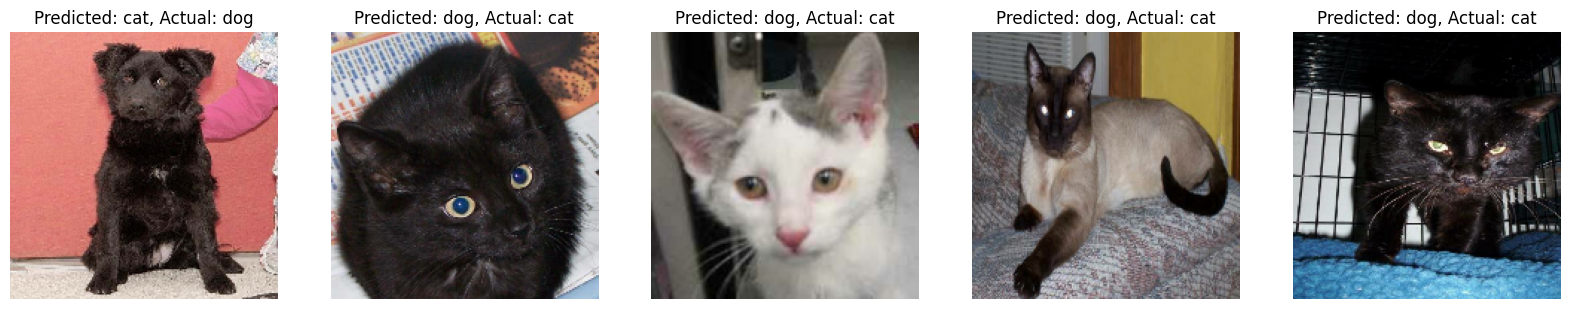

In [134]:
# Show wrong predictions from the Vanilla CNN model
classes = test_dataset.class_names
vanilla_wrong_indices = np.where(y_pred_vanilla != test_labels.reshape(-1,1))[0]

print("Some examples where the Vanilla CNN model made wrong predictions:")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.ravel()

for ax, i in zip(axes, vanilla_wrong_indices[:5]):
    ax.imshow(test_images[i].astype("uint8"))
    ax.set_title(f"Predicted: {classes[y_pred_vanilla[i][0]]}, Actual: {classes[test_labels[i]]}")
    ax.axis('off')

Some examples where the Fine Tuned VGG model made wrong predictions:


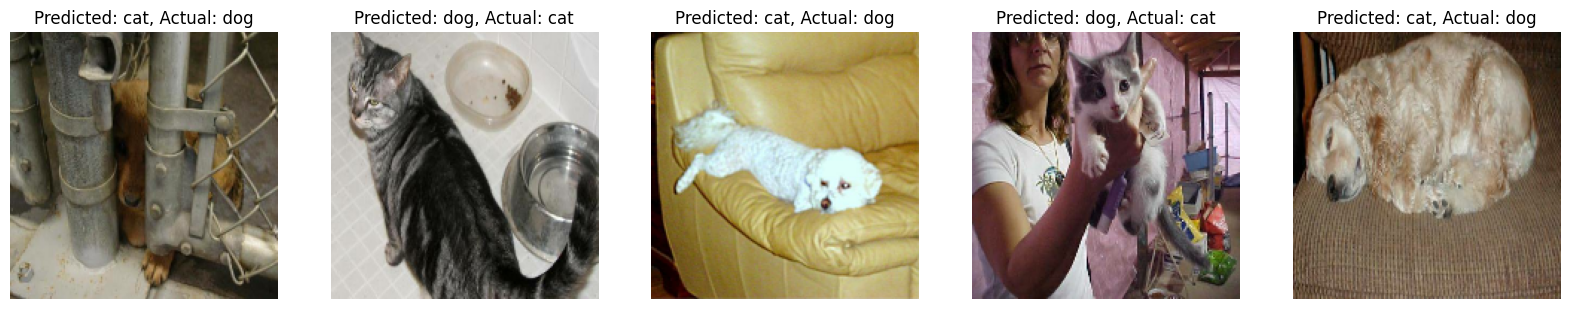

In [135]:
# Show wrong predictions from the Fine tunded VGG model
vgg_wrong_indices = np.where(y_pred_vgg != test_labels.reshape(-1,1))[0]

print("Some examples where the Fine Tuned VGG model made wrong predictions:")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.ravel()

for ax, i in zip(axes, vgg_wrong_indices[:5]):
    ax.imshow(test_images[i].astype("uint8"))
    ax.set_title(f"Predicted: {classes[y_pred_vgg[i][0]]}, Actual: {classes[test_labels[i]]}")
    ax.axis('off')

We see that while the Vanilla CNN model misclassifies some images that are even glaring to the human eye, like the 3rd and 4th images in the visualization, the images that the Fine tuned VGG16 model misclassifies are actually confusing images and could be confusing to the human eye. Some of the images has some objects blocking the features of the animal like in the first image on the second visual.

**Conclusion:**

The results from our experiments demonstrate that fine-tuning VGG16 outperforms the Vanilla CNN in terms of accuracy, precision, recall, and f1-score. The Precision-Recall curve shows that the fine-tuned VGG16 maintains high precision across various recall levels, while the Vanilla CNN struggles with a significant drop in precision as recall increases. This highlights the effectiveness of transfer learning, where leveraging pre-trained models on large datasets improves classification performance, especially in cases with limited training data. Overall, fine-tuning deep learning models can lead to better generalization and more reliable predictions.